If you wish to run the following code, please download the original Arxiv dataset from: https://www.kaggle.com/datasets/Cornell-University/arxiv?datasetId=612177&sortBy=dateRun&tab=profile and the “general_topics.txt file from my repository at: https://github.com/ricardocolindres/Topic-Modeling-Arxiv-Dataset

# Categorizing Trends in Science
### Arxiv Dataset
Data Science is a broad field of study that has even broader implementations. According to Kelleher and Tierney (2018) in their book Data Science, “data science encompasses a set of principles, problem definitions, algorithms, and processes for extracting non-obvious and useful patterns from large datasets”. Data processing and analysis are of critical importance for scientists from all backgrounds to generate the proper understanding of any research conducted. Therefore, for companies offering data analysis services for the scientific community (e.g., the one subject of this case of study), it is important to identify the scientific trends that are undergoing constant growth, investigation, and experimentation to establish professional and business cooperation with their respective communities. Thus, the main goal of the following project is to identify the current scientific trends by analyzing over two million scientific papers and derive the corresponding scientific sectors (i.e., the companies conducting research and development in different scientific fields) in need of high-quality data science services. This will enable the data science company subject of this report to yield rapid and consistent growth by timely targeting the right costumers. 

The data that has been used in this report to produce the necessary insight was extracted from the ArXiv dataset. The ArXiv dataset contains over two million data points (i.e., scholarly articles). Each data point is described by fourteen (14) attributes some of which will be relevant to this report and the models constructed within it. According to ArXiv, the owner of the database analyzed in this report, “for nearly 30 years, ArXiv has served the public and research communities by providing open access to scholarly articles, from the vast branches of physics to the many subdisciplines of computer science to everything in between, including math, statistics, electrical engineering, quantitative biology, and economics. This rich corpus of information offers significant, but sometimes overwhelming depth” (Cornell University, 1991). The approach that has been used to extract the scientific trends present in this massive database is a subcategory of natural language processing called topic modeling. Furthermore, the report iterates over a couple of dimensionality reduction methods that can model this non-linearly correlated vectorized data (i.e., text data represented numerically) and provide a visual representation of the clusters conformed by the related extracted topics. In the following sections, each step taken to produce the discussed results has been carefully recorded and examined to generate a complete understanding of the data and the relevant underlying topics and corresponding clusters derived from this massive data dataset.


In [1]:
import dask.bag as db #dask 
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sentence_transformers import SentenceTransformer
import hdbscan
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import logging # mainly use to hide or supress deprecation warnings

logging.captureWarnings(True)


pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 150

2023-03-21 20:44:58.124139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 20:44:58.184563: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Loading the Data

The ArXiv dataset a is available in the json format and although the actual articles have been excluded, its size is over three (3) gigabytes. Due to the sheer amount of data present in this dataset, the loading and manipulation processes of the data are to be carefully considered, especially when using local computational resources (i.e., using a personal computer). Consequently, the data have been loaded using the Dask Framework, specifically, the Dask Bag class. Dask has optimized this class for parallel computing and proper management of multicore-capable CPUs and GPUs. Therefore, it yields much better results compared to simply loading the file using the standard JSON library. After having loaded the data successfully, the data will be filter and processed before undergoing exploratory data analysis (EDA). 

In [4]:
# Dask was developed to natively scale packages like Numpy, pandas and scikit-learn and the surrounding ecosystem to multi-core machines and distributed clusters when datasets exceed memory.
# Cited from https://www.dask.org/
# Load data using Dask's Bag object. Which, according to my local environment, is about 3 times faster compared to loading the dataset strictly using the "json" library. 
loaded_data = db.read_text('arxiv-db.json').map(json.loads)

In [5]:
#Check Loaded Data
print("The dataset has {} entires.".format(loaded_data.count().compute()))
print("Data Structure:")
loaded_data.take(1)

The dataset has 2207558 entires.
Data Structure:


({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

### Feature Transformations 

Before making use of the data to extract trending topics from it, it is necessary to improve the structure of the dataset to have a better representation of the underlying topics. The first step towards improving the data structure is to interpret the codified “category” attribute included in the dataset. This attribute describes each article’s main topics but has been codified into acronyms that provide little information and are not suitable for vectorization (i.e., transforming text into numerical representations). Therefore, the attribute has been interpreted and transformed into three additional features. Those features are the following: main-category, sub-category, and category description. All these newly created features are in a human-readable format (i.e., text). To generate and populate the proposed features, a function was written to extract, transform and load these fields. This function matches the acronym contained in the original “category” attribute with additional data published in the Arxiv dataset website found at https://arxiv.org/category_taxonomy. Performing this transformation will generate a quick insight into the distribution of the main categories included in the articles. Furthermore, once all this data has been vectorized and then reduced in dimensionality, the data points that share all or some main categories, sub-categories, and descriptions will be pushed together into more homogeneous clusters. The reason of all this will be further explored in the upcoming sections. Finally, generating these features will greatly benefit the exploratory data analysis process. 

In [6]:
#Load data extracted from the Arxiv's website
with open('general_topics.txt') as f:
    lines = f.readlines()

#Check first 10 lines of the data loaded to understand the patterns and structure present. 
print(*lines[:5], sep='\n')

cs.AI (Artificial Intelligence)

This category covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. 

cs.AR (Hardware Architecture)

This category covers systems organization and hardware architecture  

cs.CC (Computational Complexity)



In [7]:
#Define categories and the codes used by the original Arxiv dataset to represent these categories.
categories = {
    'computer science' : 'cs',
    'economics' : 'econ',
    'electrical engineering and system science' : 'eess',
    'mathematics' : 'math',
    'physics - astrophysics' : 'astro-ph',
    'physics - condensed matter' : 'cond-mat',
    'physics - general relativity and quantum cosmology' : 'gr-qc',
    'physics - high energy physics - experiment' : 'hep-ex',
    'high energy physics - lattice' : 'hep-lat',
    'high energy physics - phenomenology' : 'hep-ph',
    'high energy physics - theory' : 'hep-th',
    'mathematical physics' : 'math-ph',
    'physics - nonlinear sciences' : 'nlin',
    'physics - nuclear theory' : 'nucl-th',
    'physics - nuclear experiment' : 'nucl-ex', 
    'physics' : 'physics',
    'quantum physics' : 'quant-ph',
    'quantitative biology' : 'q-bio',
    'quantitative finance' : 'q-fin',
    'statistics' : 'stat',
    }

In [8]:
#Define function to structure the new loaded data (lines) from the ArXiv Website
def process_text(text):
    cleaned_list = []
    for l in text:
        if "\n" in l:
            l =  re.sub("\n", "", l)
        cleaned_list.append(l)

    pre_categories = cleaned_list[::2]
    categories_descriptions = cleaned_list[1::2]
    cleaned_list = []

    for i, v in enumerate(pre_categories):
        topic_start = v.find('(')
        topic_end = v.find(')')
        sub_category = v[topic_start+1:topic_end].strip().lower()
        category  = (v[:topic_start]).strip().lower()
        if '.' in category:
            main_category = category[:(category.find('.'))].lower()
        else:
            main_category = category.lower()

        for k, value in categories.items():
            if value == main_category:
                main_category = k.lower()
        
        categories_description = categories_descriptions[i].strip()
        if categories_description[-1] != '.':
            categories_description = categories_description + '.'

        # (cs.ai, computer science, artificial intelligence, descripcion) Example of new data format
        new_features = (category, main_category, sub_category, categories_description)
        cleaned_list.append(new_features)
       
    return cleaned_list

cleaned_new_data = process_text(lines)

#These tuples will be used to match each category's acronym and generate newly proposed features.
print(*cleaned_new_data[:5], sep='\n')

('cs.ai', 'computer science', 'artificial intelligence', 'This category covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI.')
('cs.ar', 'computer science', 'hardware architecture', 'This category covers systems organization and hardware architecture.')
('cs.cc', 'computer science', 'computational complexity', 'This category covers models of computation, complexity classes, structural complexity, complexity tradeoffs, upper and lower bounds. Roughly includes material in computation by abstract devices, tradeoffs among complexity measures, and formal languages, although some material in formal languages may be more appropriate for Logic in Computer Science.')
('cs.ce', 'computer science', 

### Filtering and Cleaning Data
This dataset contains 2,207,558 data points. To yield better results, the data set will be filtered down to fewer and more relevant data points.  Relevance is an arbitrary concept in this case mainly because of the definition of a “trend”. For this case study, trends have been defined as those topics that have remained relevant and investigated for at least the past four (4) years. This filtering process will be applied to the Dask Bag Object to speed up the process. Moreover, the actual transformation of the feature discussed in the previous section was run at this stage. The result was then converted into a Panda’s data frame. Finally, the 4-year time frame considers any scientific article that has been created or updated within this period of time. The keyword here is “updated”. Some of the research papers in this dataset were created over a decade ago; however, if these papers keep getting updates, it is most likely because the topics of research contained in the articles are still relevant and under investigation. Therefore, the attributes considered in the filtering process were the “version” and “update_date” columns. Finally, after running the code, the data set was reduced to 662,346 data point. Moreover, the constructed data frame contains the newly extracted features. Finally, some data types were modified to match their nature (e.g., dates were transformed into datetimes data types) and facilitate data manipulation processes.

In [9]:
# Define a function that returns the lastest year the paper was either published or updated. This function will be bases to the bag.filter() method.
def get_last(x):
    get_latest_version = int((x['versions'][-1]['created']).split(' ')[3])
    get_latest_update = int((x['update_date']).split('-')[0])
    last_date = max([get_latest_version, get_latest_update])
    return last_date
                            
# Define a function that retunrs only the relevant attributes
trim_attributes = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],
                  'versions':x['versions'],
                  'update_date':x['update_date'],}

# Filter all articles that have ramained relevant or mostly investigated for at least the past 5 years
columns = ['id','category','abstract']
loaded_data = (loaded_data.filter(lambda x: get_last(x=x) > 2019).map(trim_attributes).compute())

# convert to pandas
df = pd.DataFrame(loaded_data)

#check data frame
df.head()

,id,authors,title,category,abstract,versions,update_date
0,0704.0033,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra",Convergence of the discrete dipole approximation. I. Theoretical\n analysis,"[physics.optics, physics.comp-ph]",We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 15:34:25 GMT'}, {'version': 'v2', 'created': 'Tue, 29 Mar 2022 18:21:31 GMT'}]",2022-03-31
1,0704.0038,"Maxim A. Yurkin, Alfons G. Hoekstra",The discrete dipole approximation: an overview and recent developments,"[physics.optics, physics.comp-ph]","We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 16:25:01 GMT'}, {'version': 'v2', 'created': 'Tue, 29 Mar 2022 17:39:15 GMT'}]",2022-03-30
2,0704.0275,George M. Bergman (U.C.Berkeley),Mapping radii of metric spaces,[math.MG],"It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...","[{'version': 'v1', 'created': 'Mon, 2 Apr 2007 21:53:20 GMT'}, {'version': 'v2', 'created': 'Fri, 28 Mar 2008 16:40:54 GMT'}]",2021-10-15
3,0704.0479,T.Geisser,The affine part of the Picard scheme,"[math.AG, math.KT]",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"[{'version': 'v1', 'created': 'Wed, 4 Apr 2007 00:17:55 GMT'}, {'version': 'v2', 'created': 'Mon, 16 Apr 2007 04:32:14 GMT'}, {'version': 'v3', 'c...",2021-01-29
4,0704.0752,Davoud Kamani,Actions for the Bosonic String with the Curved Worldsheet,[hep-th],"At first we introduce an action for the string, which leads to a worldsheet\nthat always is curved. For this action we study the Poincar\'e symm...","[{'version': 'v1', 'created': 'Thu, 5 Apr 2007 16:04:35 GMT'}, {'version': 'v2', 'created': 'Sat, 28 Apr 2007 06:00:42 GMT'}, {'version': 'v3', 'c...",2020-08-21


In [10]:
#Check data frame size
df.shape

(662346, 7)

In [11]:
#Check info and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662346 entries, 0 to 662345
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           662346 non-null  object
 1   authors      662346 non-null  object
 2   title        662346 non-null  object
 3   category     662346 non-null  object
 4   abstract     662346 non-null  object
 5   versions     662346 non-null  object
 6   update_date  662346 non-null  object
dtypes: object(7)
memory usage: 35.4+ MB


In [12]:
#Check null values
df.category.isnull().sum()

0

In [13]:
#Define function to generate new features
def category_extraction(x):
    new_category = []
    for i in x:
        i = i.lower()
        for tup in cleaned_new_data:
            if i == tup[0]:
                new_category.append('"' + tup[1] + '"') #IMPORT TO ADD QUOTES TO THE NEW CATEGORY, OTHERWISE IS IT GOING TO BE HARD TO PERFORM EDA
                break
            elif i in tup[0]:
                new_category.append('"' + tup[1] + '"')
                break
    new_category = list(set(new_category))
    return new_category 

def subcategory_extraction(x):
    new_subcategory = []
    for i in x:
        i = i.lower()
        for tup in cleaned_new_data:
            if i == tup[0]:
                new_subcategory.append('"' + tup[2] + '"')
                break
            elif i in tup[0]:
                new_subcategory.append('"' + tup[2] + '"')
                break
    new_subcategory = list(set(new_subcategory))
    return new_subcategory 

def description_extraction(x):
    new_description = []
    for i in x:
        i = i.lower()
        for tup in cleaned_new_data:
            if i == tup[0] and tup[3] != 'Description coming soon.':
                new_description.append(tup[3])
                break
            elif i in tup[0] and tup[3] != 'Description coming soon.':
                new_description.append(tup[3])
                break
    new_description = list(set(new_description))
    if len(new_description) > 1:
        new_description = ' Also, '.join(new_description)
    elif len(new_description) == 0:
        new_description = None
    else:
        new_description = new_description[0]

    return new_description 

def last_creation_date(x):
    last_date = (x[-1]['created']).split(' ')
    last_date = last_date[1] + ' ' + last_date[2] + ' ' + last_date[3] 
    return last_date

In [14]:
# Generate new features by traforming the old category attribute and filter data
df['new_category'] = df['category'].apply(lambda x: category_extraction(x=x))
df['sub_category'] = df['category'].apply(lambda x: subcategory_extraction(x=x))
df['description'] = df['category'].apply(lambda x: description_extraction(x=x))
df['update_date'] = pd.to_datetime(df['update_date'])
df['created_date'] = pd.to_datetime(df['versions'].apply(lambda x: last_creation_date(x=x)))
df = df.reindex(columns=['id', 'title', 'authors', 'category', 'new_category', 'sub_category', 'created_date', 'update_date', 'description', 'abstract', 'versions'])

In [15]:
pd.options.display.max_rows = 1000
df.head()

,id,title,authors,category,new_category,sub_category,created_date,update_date,description,abstract,versions
0,0704.0033,Convergence of the discrete dipole approximation. I. Theoretical\n analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[physics.optics, physics.comp-ph]","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 15:34:25 GMT'}, {'version': 'v2', 'created': 'Tue, 29 Mar 2022 18:21:31 GMT'}]"
1,0704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[physics.optics, physics.comp-ph]","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 16:25:01 GMT'}, {'version': 'v2', 'created': 'Tue, 29 Mar 2022 17:39:15 GMT'}]"
2,0704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),[math.MG],"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...","[{'version': 'v1', 'created': 'Mon, 2 Apr 2007 21:53:20 GMT'}, {'version': 'v2', 'created': 'Fri, 28 Mar 2008 16:40:54 GMT'}]"
3,0704.0479,The affine part of the Picard scheme,T.Geisser,"[math.AG, math.KT]","[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"[{'version': 'v1', 'created': 'Wed, 4 Apr 2007 00:17:55 GMT'}, {'version': 'v2', 'created': 'Mon, 16 Apr 2007 04:32:14 GMT'}, {'version': 'v3', 'c..."
4,0704.0752,Actions for the Bosonic String with the Curved Worldsheet,Davoud Kamani,[hep-th],"[""high energy physics - theory""]","[""high energy physics - theory""]",2008-04-18,2020-08-21,"This category includes formal aspects of quantum field theory. String theory, supersymmetry and supergravity.","At first we introduce an action for the string, which leads to a worldsheet\nthat always is curved. For this action we study the Poincar\'e symm...","[{'version': 'v1', 'created': 'Thu, 5 Apr 2007 16:04:35 GMT'}, {'version': 'v2', 'created': 'Sat, 28 Apr 2007 06:00:42 GMT'}, {'version': 'v3', 'c..."


In [16]:
#Save filtered and cleaned data into a csv filed
df.to_csv('filtered_arxiv_db.csv', index = False)

### Re-Load Transformed and Cleaned Data
This step is just here to speed up the loading process in the future

In [15]:
#Load transformed data and drop non-relevant columns
df = pd.read_csv('filtered_arxiv_db.csv')
df[['created_date', 'update_date']] = df[['created_date', 'update_date']].apply(pd.to_datetime)
df = df.drop(['versions', 'category'], axis=1)
df.columns = ['id', 'title', 'authors', 'category', 'sub_category', 'published_date', 'updated_date', 'description', 'abstract']
df["category"] = df["category"].apply(eval)
df["sub_category"] = df["sub_category"].apply(eval)
df.head()

,id,title,authors,category,sub_category,published_date,updated_date,description,abstract
0,704.0033,Convergence of the discrete dipole approximation. I. Theoretical\n analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...
1,704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa..."
2,704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L..."
3,704.0479,The affine part of the Picard scheme,T.Geisser,"[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n
4,704.0752,Actions for the Bosonic String with the Curved Worldsheet,Davoud Kamani,"[""high energy physics - theory""]","[""high energy physics - theory""]",2008-04-18,2020-08-21,"This category includes formal aspects of quantum field theory. String theory, supersymmetry and supergravity.","At first we introduce an action for the string, which leads to a worldsheet\nthat always is curved. For this action we study the Poincar\'e symm..."


### Exploratory Data Analysis (EDA)
Moving on, to have a better understanding of the data, a basic exploratory data analysis process has been performed on the dataset in this section. After running some code, the key takeaways from this process are the following:

1.- The “description” attribute contains some null values. This is not of concern since the only purpose of this field is to be merged into the “abstract” field in the vectorization process to add and enrich the context of each article’s abstract and thus derive better clusters or groups of related articles. 

2.- The articles’ categories has been analyzed to understand how they are distributed across the dataset. For example, it has been concluded that the category with the largest number of papers is “computer science” followed by “mathematics”. Although this report is not after these categories or broader topics, from these categories a very well-rounded picture can be depicted regarding the structure of the trending topics. Finally, the association among these categories has been studied and visualized utilizing a heatmap. This is not so relevant for clustering, dimensionality reduction or natural language processing; however, it is certainly important for real-world applications such as implementing supervised learning algorithms to optimize the searching process across the database. For instance, the results reveal that computer science topics are highly associated with mathematics and statistics articles, which might suggest some unusually high activity in fields such as data science and artificial intelligence. Although generating these supervised models is outside the scope of this article, it is worth mentioning that this data could be further expanded by analyzing the sub-categories of each article as well. 



In [16]:
df.isnull().sum()

id                    0
title                 0
authors               0
category              0
sub_category          0
published_date        0
updated_date          0
description       24068
abstract              0
dtype: int64

In [17]:
df.shape

(662346, 9)

In [18]:
def to_one_dimension(series):
    return pd.Series([x for _list in series for x in _list])
df_category = to_one_dimension(df['category'])
unique_value_counts = df_category.value_counts().values
unique_values = df_category.value_counts().index.to_list()

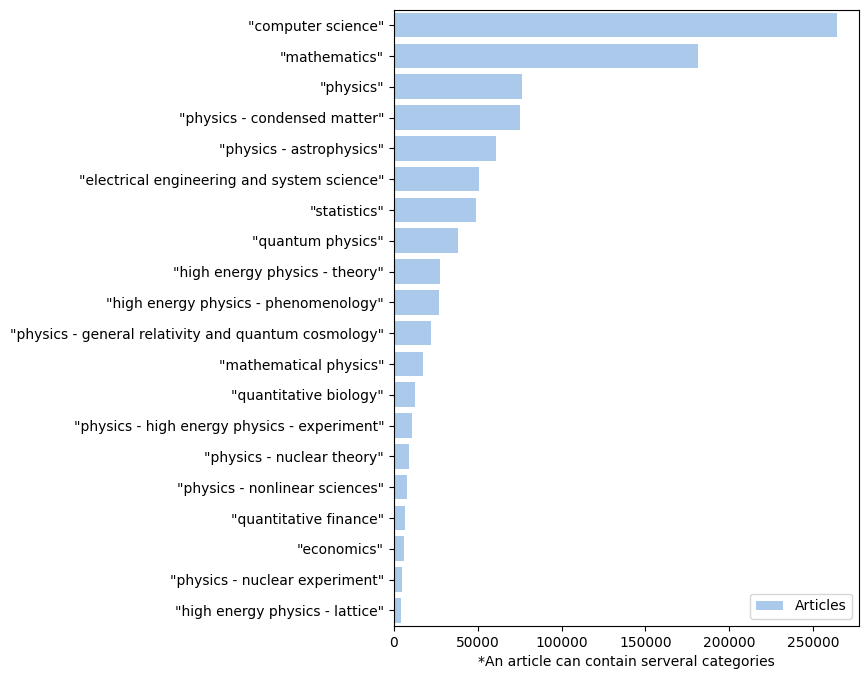

In [19]:
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes("pastel")
sns.barplot(x=unique_value_counts, y=unique_values,label="Articles", color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="*An article can contain serveral categories")
plt.show()

In [20]:
def boolean_df(categories_lists, unique_items):
    # Create empty dict
    bool_dict = {}
    # Loop through all the tags
    for category in unique_items:
        # Apply boolean mask
        bool_dict[category] = categories_lists.apply(lambda x: category in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [21]:
categories_bool = boolean_df(categories_lists = df["category"], unique_items = unique_values)
categories_bool.head()

,"""computer science""","""mathematics""","""physics""","""physics - condensed matter""","""physics - astrophysics""","""electrical engineering and system science""","""statistics""","""quantum physics""","""high energy physics - theory""","""high energy physics - phenomenology""","""physics - general relativity and quantum cosmology""","""mathematical physics""","""quantitative biology""","""physics - high energy physics - experiment""","""physics - nuclear theory""","""physics - nonlinear sciences""","""quantitative finance""","""economics""","""physics - nuclear experiment""","""high energy physics - lattice"""
0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [22]:
categories_freq = categories_bool.astype(int)
categories_freq.head()

,"""computer science""","""mathematics""","""physics""","""physics - condensed matter""","""physics - astrophysics""","""electrical engineering and system science""","""statistics""","""quantum physics""","""high energy physics - theory""","""high energy physics - phenomenology""","""physics - general relativity and quantum cosmology""","""mathematical physics""","""quantitative biology""","""physics - high energy physics - experiment""","""physics - nuclear theory""","""physics - nonlinear sciences""","""quantitative finance""","""economics""","""physics - nuclear experiment""","""high energy physics - lattice"""
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [23]:
categories_freq_mat = np.dot(categories_freq.T, categories_freq)
categories_freq = pd.DataFrame(categories_freq_mat,columns = unique_values,index =unique_values)
categories_freq.head()

,"""computer science""","""mathematics""","""physics""","""physics - condensed matter""","""physics - astrophysics""","""electrical engineering and system science""","""statistics""","""quantum physics""","""high energy physics - theory""","""high energy physics - phenomenology""","""physics - general relativity and quantum cosmology""","""mathematical physics""","""quantitative biology""","""physics - high energy physics - experiment""","""physics - nuclear theory""","""physics - nonlinear sciences""","""quantitative finance""","""economics""","""physics - nuclear experiment""","""high energy physics - lattice"""
"""computer science""",264013,43691,8517,1995,910,42749,30613,3556,179,196,140,633,4360,250,27,757,1483,1432,16,95
"""mathematics""",43691,181232,4221,3598,317,7894,12102,4065,4982,280,1864,17519,1566,3,59,2633,1099,677,0,125
"""physics""",8517,4221,76190,16922,5158,2554,1652,7220,615,1099,872,959,2908,2570,423,2424,406,333,921,116
"""physics - condensed matter""",1995,3598,16922,75246,332,162,491,10715,3616,588,548,2583,1052,64,477,1768,69,31,54,638
"""physics - astrophysics""",910,317,5158,332,60965,141,263,189,3412,5865,7811,114,43,1093,1135,163,4,4,315,49


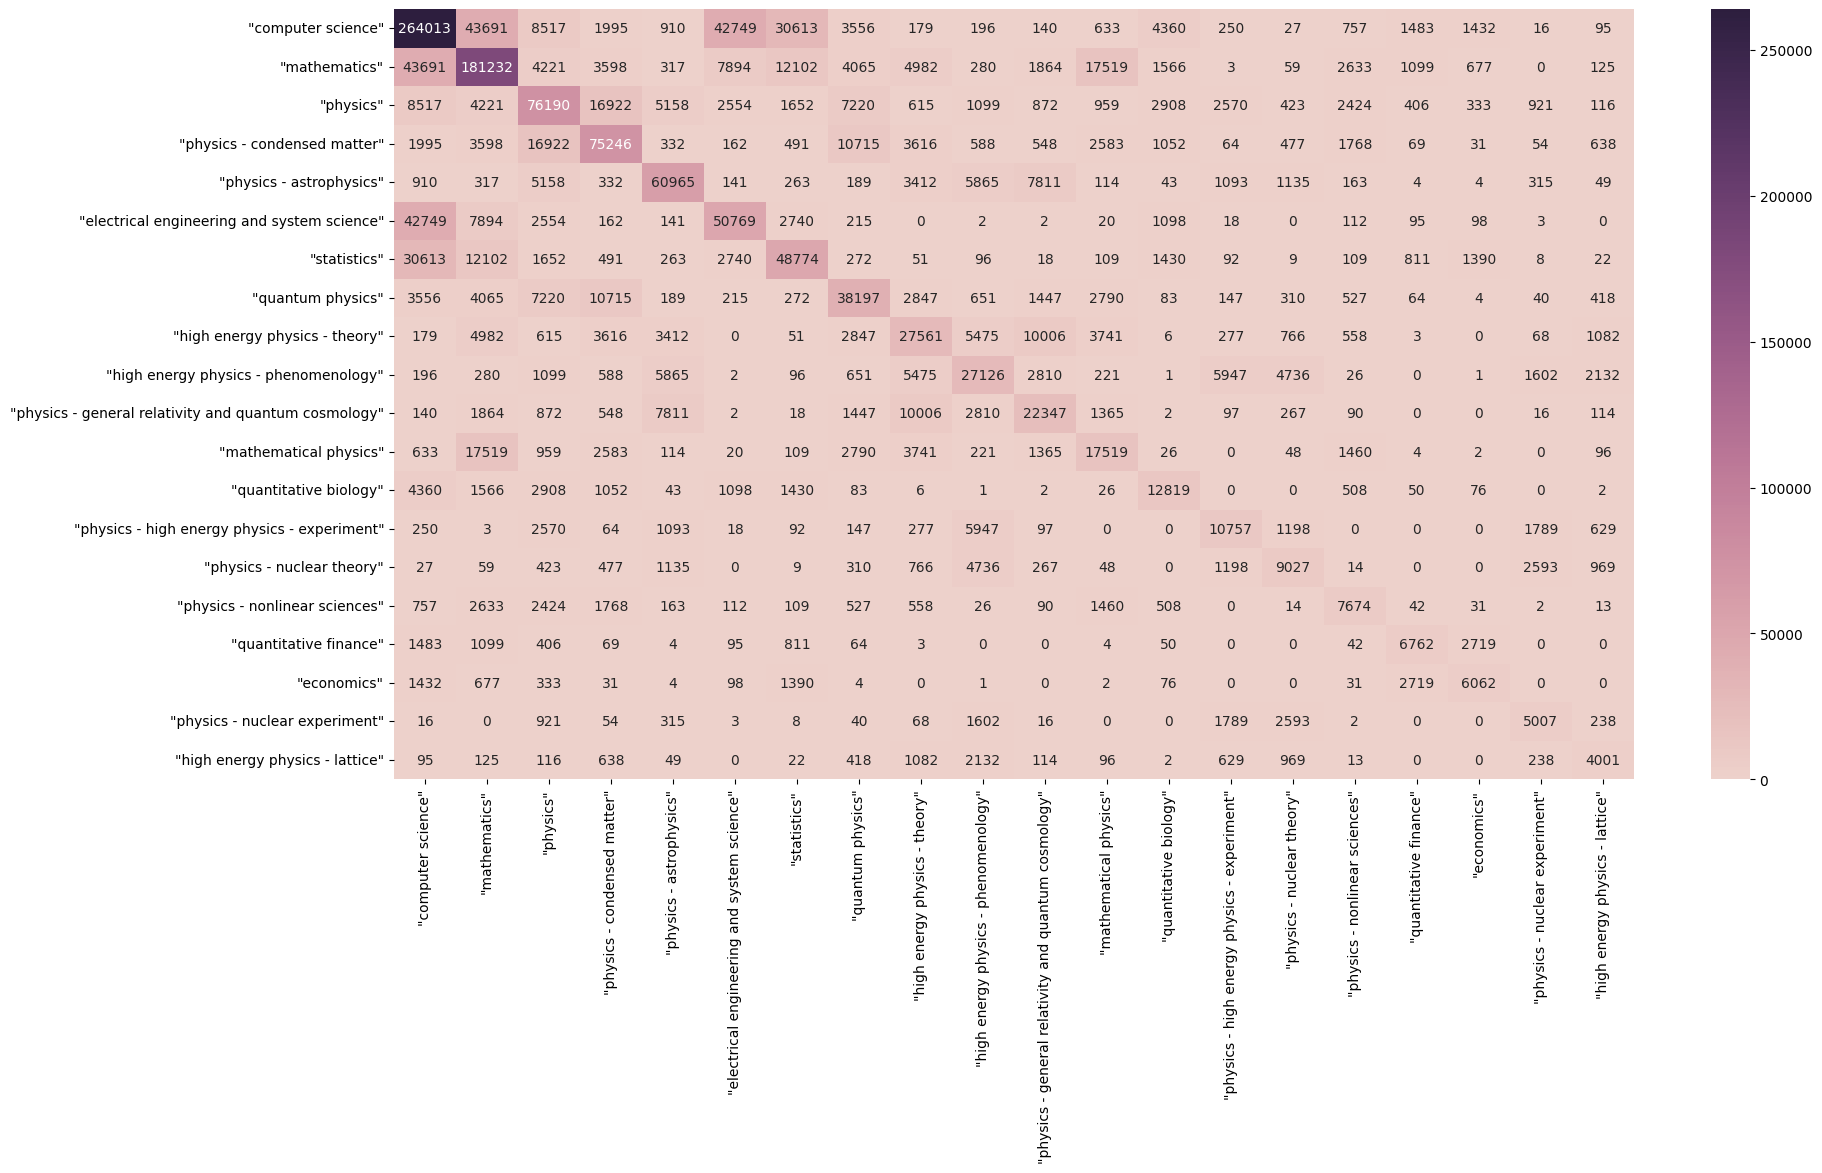

In [24]:
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(categories_freq, cmap = sns.cubehelix_palette(as_cmap=True), annot=True, fmt="")
plt.xticks(rotation=90)
plt.show()

### Feature Engineering and Clustering
Before going any further into the extraction of the trending topics comprised in this massive dataset, let’s explore the methodology that was used to accomplish this goal. There is no obvious or straightforward method to approach this problem. In fact, topic modeling is a very large field of study within the natural language processing community. To exemplify this, let’s say that a simple TF-IDF algorithm is applied to the entire corpus (i.e., all the abstracts). This might seem like a good place to start, after all, TF-IDF algorithms are very good at capturing the importance that words have relative to their own containing bodies of text and all other bodies of text contained in the same dataset. However, in this case, it will certainly perform poorly. This is because the algorithm will favor those words/topics that are less frequent across a massive number of unrelated bodies of text (i.e., abstracts). Consequently, the algorithm will likely fail to model the topics. This phenomenon occurs because irrelevant topics contained in small numbers of abstracts are over-represented due to their rareness relative to the large number of unrelated abstracts that don’t contain them but rather contain other more common and relevant topics. To further exemplify this, one can refer to figure 1 where the articles’ categories have been illustrated. If a topic is extracted from an economics article (a low occurring category) and compared to the rest of the corpus, it will certainly return a high TF-IDF; however, if the opposite is done and a highly occurring category is selected such as computer science, the topics extracted from this category will return very low TF-IDF scores since the inverse document frequency is dramatically reduced by the fact that there will certainly be more articles interrelated and thus with similar topics. Therefore, the algorithm could erroneously discard relevant topics present in large number of related articles. As a result, there is a high risk of producing highly irrelevant topics that can mislead and misrepresent the true underlying structure of the dataset’s topics. To mitigate these risks and produce a fair representation of this dataset’s topics, the methodology that has been developed and implemented consists of clustering related articles before extracting any information from them. This method enables the isolated analysis of the most relevant topics within each individual cluster. Then, the topics relative importance to other clusters can be assessed to filter the most significant topics produced by each cluster. There are some libraries for topic modeling that have similar approaches; however, in this case, a specific and unique implementation of the described methodology has been developed from scratch by integrating some well-known clustering, dimensionality reduction and custom-coded algorithms. 

To begin modeling these clusters, the articles must be transformed into a numeric representation. To do so, the sentence-transformers library has been used. Sentence Transformers is a Python framework for state-of-the-art sentence, text, and image embeddings (SentenceTransformers Documentation, 2022). This embedding method is especially strong at creating and finding semantic similarities between sentences and documents. Although such a large dataset would have been a perfect candidate for training a model purely based on the data points available, the computational cost of training a model locally (i.e., on a personal computer) is too high. Thus, two pre-trained models have been tested as candidates to generate the embedding for these articles. These models are 'allenai-specter' and "all-MiniLM-L6-v2". The latter was trained with scientific articles and the former with general bodies of text found in sources like Wikipedia or Reddit. Before generating any embeddings, the abstracts were enhanced by adding a sentence with the following structure: “This article’s main category(ies) is(are) {main category(ies) to which the article belongs}. Some topics related to these articles include: {sub-categories}”. This sentence was automatically generated based on the features (i.e., the categories and subcategories) extracted in the previous sections. Following this sentence, the descriptions of the categories corresponding to each article were also added into the abstract in a syntactically coherent manner. The purpose of such enhancement is to aid the embedding process in pushing related vectors (i.e., the numerical representation of abstracts) together in high-dimensional vector spaces. After carefully evaluating both pre-trained models, the one that produced the best results (i.e., created the best clusters) was 'allenai-specter'. However, this model generates embedding in 768 dimensions. Before moving on, it’s important to mention that generating these embeddings takes an enormous amount of time on a local computer; therefore, it limits the number of pre-trained models and variants of the dataset that can be tested.

Following, before one can implement any clustering method, it is important to reduce the dimensionality of these embeddings. Otherwise, the clustering methods will perform poorly due to the so-called curse of dimensionality. In this case, UMAP or Uniform Manifold Approximation and Projection Method has been chosen as the dimensionality reduction algorithm of preference because of its capacity to work with non-linear data. Finally, after tuning this algorithm and reducing the embeddings from 768 dimensions to 15 dimensions, the clusters can now be extracted. To do so, two clustering methods were tested. The first one tested was HDBSCAN or Hierarchical Density Bases Spatial Clustering of Application with Noise, which is a hybrid between hierarchical and density-based clustering algorithms. This algorithm was chosen as a candidate due to its capacity of handling noisy data and finding clusters with amorphous shapes. Moreover, it is optimized to work with large datasets. Next, sci-kit-learn’s K-means algorithm was assessed. This is a simpler algorithm only capable of producing perfectly spherical clusters. The algorithms were evaluated using the density-based clustering validating metric for the HDBSCAN and the elbow and silhouette method for the K-means. Of course, they were also both further tested down the road by observing the quality of the topics both clustering methods generated.

The results produced from the exhausting testing phase were the following: HDSCAN created 219 clusters after finding the optimal hyperparameters. This might seem high at first but if one considers the size of the dataset, 219 clusters are totally doable. However, two aspects of this clustering method were of great concern. First, almost one-fourth of all data points were considered outliers or noise. Second, the algorithm created a cluster that included almost one-sixth of all data points. On the other hand, k-means was generating visually coherent clusters in two dimensions, but those clusters had a poor silhouette score of 0.47 at the suggested k number (i.e., the number of clusters) by the elbow method. To plot the clusters and visually evaluate both clustering algorithms, two-dimensional embeddings were created using the UMAP method again. However, the data points were color-coded using the clusters generated from the embeddings in 15 dimensions. After thoroughly evaluating both methods, HDBSCAN rendered better results. Nonetheless, some decisions had to be taken regarding the concerns previously mentioned regarding this clustering method. First, all outliers (i.e., abstracts) were removed and not considered candidates for topic modeling. This makes sense because if these documents are true outliers, the process of extracting topics from them will produce isolated topics that are, by no mean, a trend. After all, the main goal is to extract trending or highly relevant topics and since these isolated articles are not representative of any given cluster, one can safely assume that the topics they contain cannot be considered trends but rather rare occurrences. Moreover, the computational cost is of great concern when working with large datasets, thus, removing these outliers will greatly benefit the processing times. Next, after exploring the unusually sized cluster previously mentioned, it was clear that the model had clustered together these articles due to their actual similarities. As one can notice from figure 1, a considerable number of categories are related to physics but are separated into related categories. Therefore, the clustering algorithm pushed them together into one single cluster. To prevent this cluster from causing an under-representation of topics within other much smaller clusters, this unusually large cluster was independently evaluated in the topic extraction process. Although the bagging and TF-IDF scores used to model the topic in the next section were normalized to account for the obvious fact that clusters have different sizes, clusters with very large differences in size can still cause misinterpretation of the scores. It is important to mention that a large number of data points within this large cluster do not necessarily means that the topics contained here are more relevant. It could possibly be that the original dataset is heavily used by physicists, astronomers, or other related scientists and thus contains more documents related to these topics. Also, it is possible that these fields of science publish articles much more frequently than other fields. Nonetheless, the size of the clusters could easily be used as a weight that influences the importance of the extracted topics if one would like to do so. For the sake of this report, the topics of this unusual cluster will be reported separately. The most important topics extracted from this cluster were filtered by evaluating their relative importance to those contained in all other clusters; however, the importance of topics contained in all other clusters was not assessed in relation to this cluster to prevent misrepresentation problems. In the next section, the methods used to extract the topics will be introduced and all this will be further clarified.


In [26]:
df.description.fillna(value='No further description available.', inplace=True)
df.isnull().sum()

id                0
title             0
authors           0
category          0
sub_category      0
published_date    0
updated_date      0
description       0
abstract          0
dtype: int64

In [27]:
def create_topic_sentence(categories, sub_categories):

    sentences = []
    for i, v in enumerate(categories):

        sentence = ''
        if len(v) == 1 and len(sub_categories[i]) == 1:
            sentence = f"This article's main category is {v[0]}. Some topics related to this article include: {sub_categories[i][0]}."
        elif len(v) == 1 and len(sub_categories[i]) > 1:
            sentence = f"This article's main category is {v[0]}. Some topics related to this article include: {', '.join(sub_categories[i])}."
        elif len(v) > 1 and len(sub_categories[i]) == 1:
            sentence = f"This article's main categories are {', and '.join(v)}. Some topics related to this article include: {sub_categories[i][0]}."
        else:   
            sentence = f"This article's main categories are {', and '.join(v)}. Some topics related to this article include: {', '.join(sub_categories[i])}."
        
        sentences.append(sentence.replace('"', ''))

    return pd.Series(sentences)

df['topic_sentence'] = create_topic_sentence(df['category'].to_list(), df['sub_category'].to_list())
df.head()

,id,title,authors,category,sub_category,published_date,updated_date,description,abstract,topic_sentence
0,704.0033,Convergence of the discrete dipole approximation. I. Theoretical\n analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"This article's main category is physics. Some topics related to this article include: computational physics, optics."
1,704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","This article's main category is physics. Some topics related to this article include: computational physics, optics."
2,704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...",This article's main category is mathematics. Some topics related to this article include: metric geometry.
3,704.0479,The affine part of the Picard scheme,T.Geisser,"[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"This article's main category is mathematics. Some topics related to this article include: k-theory and homology, algebraic geometry."
4,704.0752,Actions for the Bosonic String with the Curved Worldsheet,Davoud Kamani,"[""high energy physics - theory""]","[""high energy physics - theory""]",2008-04-18,2020-08-21,"This category includes formal aspects of quantum field theory. String theory, supersymmetry and supergravity.","At first we introduce an action for the string, which leads to a worldsheet\nthat always is curved. For this action we study the Poincar\'e symm...",This article's main category is high energy physics - theory. Some topics related to this article include: high energy physics - theory.


In [28]:
df['unifed_text'] = df['abstract'] + '[SEP]' + df['topic_sentence'] + '[SEP]' + df['description'] + '[SEP]'
df.head()

,id,title,authors,category,sub_category,published_date,updated_date,description,abstract,topic_sentence,unifed_text
0,704.0033,Convergence of the discrete dipole approximation. I. Theoretical\n analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"This article's main category is physics. Some topics related to this article include: computational physics, optics.",We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...
1,704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","This article's main category is physics. Some topics related to this article include: computational physics, optics.","We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa..."
2,704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...",This article's main category is mathematics. Some topics related to this article include: metric geometry.,"It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L..."
3,704.0479,The affine part of the Picard scheme,T.Geisser,"[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"This article's main category is mathematics. Some topics related to this article include: k-theory and homology, algebraic geometry.",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n[SEP]This article'...
4,704.0752,Actions for the Bosonic String with the Curved Worldsheet,Davoud Kamani,"[""high energy physics - theory""]","[""high energy physics - theory""]",2008-04-18,2020-08-21,"This category includes formal aspects of quantum field theory. String theory, supersymmetry and supergravity.","At first we introduce an action for the string, which leads to a worldsheet\nthat always is curved. For this action we study the Poincar\'e symm...",This article's main category is high energy physics - theory. Some topics related to this article include: high energy physics - theory.,"At first we introduce an action for the string, which leads to a worldsheet\nthat always is curved. For this action we study the Poincar\'e symm..."


In [29]:
def _preprocess_text(documents):
        
        """ Basic preprocessing of documents:

        Steps:
            * Replace \n and \t with whitespace
            * Only keep alpha-numerical characters
            * Lower case words and tokenization
        """
        
        cleaned_documents = [doc.replace("\n", " ") for doc in documents]
        cleaned_documents = [doc.replace("\t", " ") for doc in cleaned_documents]
        cleaned_documents = [re.sub(' +', ' ', doc) for doc in cleaned_documents]
        cleaned_documents = [doc.strip() for doc in cleaned_documents]
        #cleaned_documents = [re.sub(r'[^A-Za-z0-9 ]+', '', doc) for doc in cleaned_documents]
        #cleaned_documents = [gensim.utils.simple_preprocess(doc) for doc in cleaned_documents]
        return cleaned_documents

In [30]:
df = df.assign(text=_preprocess_text(df['unifed_text'].to_list()))
df = df.assign(title=_preprocess_text(df['title'].to_list()))
df.head()

,id,title,authors,category,sub_category,published_date,updated_date,description,abstract,topic_sentence,unifed_text,text
0,704.0033,Convergence of the discrete dipole approximation. I. Theoretical analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"This article's main category is physics. Some topics related to this article include: computational physics, optics.",We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,We performed a rigorous theoretical convergence analysis of the discrete dipole approximation (DDA). We prove that errors in any measured quantity...
1,704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","This article's main category is physics. Some topics related to this article include: computational physics, optics.","We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","We present a review of the discrete dipole approximation (DDA), which is a general method to simulate light scattering by arbitrarily shaped parti..."
2,704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...",This article's main category is mathematics. Some topics related to this article include: metric geometry.,"It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...","It is known that every closed curve of length \leq 4 in R^n (n>0) can be surrounded by a sphere of radius 1, and that this is the best bound. Lett..."
3,704.0479,The affine part of the Picard scheme,T.Geisser,"[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"This article's main category is mathematics. Some topics related to this article include: k-theory and homology, algebraic geometry.",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n[SEP]This article'...,We describe the maximal torus and maximal unipotent subgroup of the Picard variety of a proper scheme over a perfect field. [SEP]This article's ma...
4,704.0752,Actions for the Bosonic String with the Curved Worldsheet,Davoud Kamani,"[""high energy physics - theory""]","[""high energy physics - theory""]",2008-04-18,2020-08-21,"This category includes formal aspects of quantum field theory. String theory, supersymmetry and supergravity.","At first we introduce an a

In [31]:
# create enhanced abstracts
articles_text = ['[CLS]' + article[0] + '[SEP]' + article[1] for article in zip(df['title'].to_list(), df['text'].to_list())]
articles_text[:10]

["[CLS]Convergence of the discrete dipole approximation. I. Theoretical analysis[SEP]We performed a rigorous theoretical convergence analysis of the discrete dipole approximation (DDA). We prove that errors in any measured quantity are bounded by a sum of a linear and quadratic term in the size of a dipole d, when the latter is in the range of DDA applicability. Moreover, the linear term is significantly smaller for cubically than for non-cubically shaped scatterers. Therefore, for small d errors for cubically shaped particles are much smaller than for non-cubically shaped. The relative importance of the linear term decreases with increasing size, hence convergence of DDA for large enough scatterers is quadratic in the common range of d. Extensive numerical simulations were carried out for a wide range of d. Finally we discuss a number of new developments in DDA and their consequences for convergence. [SEP]This article's main category is physics. Some topics related to this article inc

In [22]:
model = SentenceTransformer('allenai-specter')
corpus_embeddings = model.encode(articles_text, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/20699 [00:00<?, ?it/s]

In [8]:
#Backup cell
corpus_embeddings_np = np.load('embeddings.npy')

In [10]:
corpus_embeddings_np.shape

(662346, 768)

In [47]:
#Don't run if backup has been run
corpus_embeddings_np = corpus_embeddings.cpu().numpy().astype(np.float64)

In [34]:
# dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine').fit_transform(corpus_embeddings_np)
umap_embeddings

array([[3.4650533 , 2.784622  , 6.025405  , 0.5409556 , 1.1171486 ],
       [5.605527  , 4.344148  , 1.5036496 , 2.4546936 , 0.88311666],
       [3.6210034 , 1.096122  , 8.233637  , 2.2068229 , 1.2747655 ],
       ...,
       [4.6693983 , 1.5307192 , 6.9988265 , 1.6009687 , 1.4693791 ],
       [4.554727  , 0.30583426, 8.477213  , 2.2867236 , 1.5470661 ],
       [6.530612  , 2.436752  , 1.0426687 , 2.0891852 , 2.1377199 ]],
      dtype=float32)

In [35]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
clusterer.fit(umap_embeddings)

HDBSCAN(min_cluster_size=200, prediction_data=True)

In [37]:
np.max(clusterer.labels_)

219

In [38]:
df['hdbscan_cluster'] = clusterer.labels_
df.head()

,id,title,authors,category,sub_category,published_date,updated_date,description,abstract,topic_sentence,unifed_text,text,hdbscan_cluster
0,704.0033,Convergence of the discrete dipole approximation. I. Theoretical analysis,"Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. Hoekstra","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-31,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,"This article's main category is physics. Some topics related to this article include: computational physics, optics.",We performed a rigorous theoretical convergence analysis of the discrete\ndipole approximation (DDA). We prove that errors in any measured quant...,We performed a rigorous theoretical convergence analysis of the discrete dipole approximation (DDA). We prove that errors in any measured quantity...,-1
1,704.0038,The discrete dipole approximation: an overview and recent developments,"Maxim A. Yurkin, Alfons G. Hoekstra","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-30,This category includes adaptive optics. Astronomical optics. Atmospheric optics. Biomedical optics. Cardinal points. Collimation. Doppler effect. ...,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","This article's main category is physics. Some topics related to this article include: computational physics, optics.","We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...","We present a review of the discrete dipole approximation (DDA), which is a general method to simulate light scattering by arbitrarily shaped parti...",59
2,704.0275,Mapping radii of metric spaces,George M. Bergman (U.C.Berkeley),"[""mathematics""]","[""metric geometry""]",2008-03-28,2021-10-15,"This category includes euclidean, hyperbolic, discrete, convex, coarse geometry, comparisons in Riemannian geometry, symmetric spaces.","It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...",This article's main category is mathematics. Some topics related to this article include: metric geometry.,"It is known that every closed curve of length \leq 4 in R^n (n>0) can be\nsurrounded by a sphere of radius 1, and that this is the best bound. L...","It is known that every closed curve of length \leq 4 in R^n (n>0) can be surrounded by a sphere of radius 1, and that this is the best bound. Lett...",-1
3,704.0479,The affine part of the Picard scheme,T.Geisser,"[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"This category includes algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology. Also, This category inc...",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,"This article's main category is mathematics. Some topics related to this article include: k-theory and homology, algebraic geometry.",We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n[SEP]This article'...,We describe the maximal torus and maximal unipotent subgroup of the Picard variety of a proper scheme over a perfect field. [SEP]This article's ma...,71
4,704.0752,Actions for the Bosonic String with the Curved Worldsheet,Davoud Kamani,"[""high energy physics - theory""]","[""high energy physics - theory""]",2008-04-18,2020-08-21,"This category includes formal aspects of quantum field theory. String theory, supersymmetry and supergravity."

In [39]:
df[df.hdbscan_cluster == -1]['id'].count()

243912

In [40]:
graph_embeddings = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit(corpus_embeddings_np)

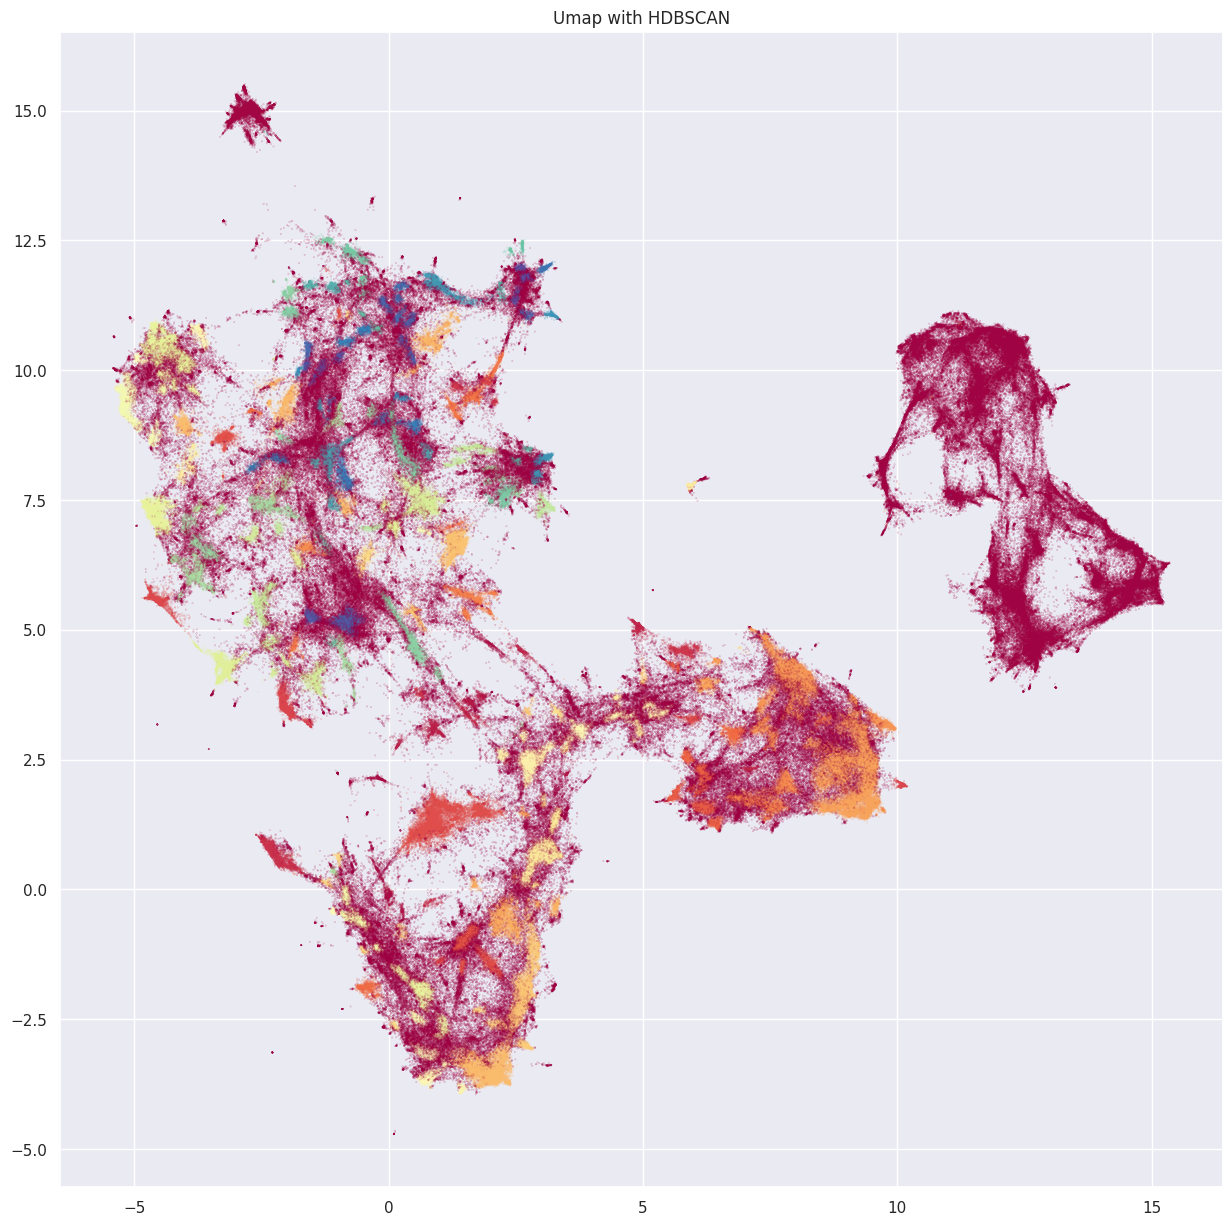

In [42]:
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
plt.scatter(graph_embeddings.embedding_[:, 0], graph_embeddings.embedding_[:, 1], s= 0.01, c=clusterer.labels_, cmap='Spectral')
plt.title('Embedding of the vectorized text set by UMAP', fontsize=24);plt.title('Umap with HDBSCAN')
plt.savefig("cluster_umap_hdbscan_labels.png")
plt.show()

In [45]:
# Save clustered data into a CVS file
df.to_csv('clustered_arxiv_db2.csv', index = False)

### Re-Load Clustered Data
This step is just here to speed up the loading process in the future

In [2]:
#Load transformed data and drop non-relevant columns
df = pd.read_csv('clustered_arxiv_db2.csv')
df[['published_date', 'updated_date']] = df[['published_date', 'updated_date']].apply(pd.to_datetime)
df["category"] = df["category"].apply(eval)
df["sub_category"] = df["sub_category"].apply(eval)
df = df.drop(['description', 'topic_sentence', 'unifed_text', 'text', 'authors'], axis=1)
df = df[df.hdbscan_cluster != -1]
df.head()

,id,title,category,sub_category,published_date,updated_date,abstract,hdbscan_cluster
1,704.0038,The discrete dipole approximation: an overview and recent developments,"[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-30,"We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped pa...",59
3,704.0479,The affine part of the Picard scheme,"[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,We describe the maximal torus and maximal unipotent subgroup of the Picard\nvariety of a proper scheme over a perfect field.\n,71
4,704.0752,Actions for the Bosonic String with the Curved Worldsheet,"[""high energy physics - theory""]","[""high energy physics - theory""]",2008-04-18,2020-08-21,"At first we introduce an action for the string, which leads to a worldsheet\nthat always is curved. For this action we study the Poincar\'e symm...",0
6,704.114,Depletion effects in smectic phases of hard rod--hard sphere mixtures,"[""physics - condensed matter""]","[""statistical mechanics"", ""soft condensed matter""]",2007-04-09,2022-06-07,"It is known that when hard spheres are added to a pure system of hard rods\nthe stability of the smectic phase may be greatly enhanced, and that...",103
7,704.1403,Equivalences of Higher Derived Brackets,"[""mathematics""]","[""quantum algebra"", ""symplectic geometry"", ""differential geometry""]",2008-05-07,2020-05-19,"This note elaborates on Th. Voronov's construction\n[math/0304038,math/0412202] of $L_\infty$-structures via higher derived\nbrackets with a Mau...",77


In [3]:
df.shape

(418434, 8)

### Topic Modeling
In this final section, the trending topics are extracted. To do so, the clusters will first be analyzed in isolation from each other. As a result, the most relevant topics within each cluster should emerge from this process. To begin, it is necessary to pre-process all the abstracts. Although we had created an enhanced version of the abstract, the raw or original abstract will be used at this stage since the enhancements sole purpose was to enrich the context within each original abstract in order to produce better clusters. The pre-processing includes the removal of none alpha-numeric characters, punctuation, unnecessary spaces, and stop words (i.e., those words that carry little semantic meaning such as articles). Moreover, all bodies of text were split into lists of words or tokens. At this point, all words were lemmatized. Lemmatizing is the process of converting words into their root word while preserving their original meaning. Lemmatization was chosen over stemming (i.e., a more aggressive method for reducing words to their roots) because of its ability to preserve the original semantic and morphological meaning although at a higher computational cost. Lemmatized words will prevent words with the same meaning from generating several topics and thus weakening their true importance. Once all abstracts have been processed, the Count-Vectorizer class available in the Sci-Kit learn library was used to extract the occurring frequency of each word within each cluster. The array returned by the fit_tranformed method of this class was then normalized using the l1 norm to account for the differences in the size of the different clusters. Finally, this data was transformed into a data frame where each row is a cluster, and each column is a word. The values in this data frame correspond to the normalized counts of occurrences of each word within each cluster. To calculate these values, all the abstracts belonging to a given cluster were joined together and individually processed. The result is a sparse matrix. 

Following, the importance of each word within each cluster was assessed relative to all other clusters. To do so, the TF-IDF score for each word was calculated. The clusters were considered as if they were a single body of text. Therefore, the data frame constructed contains clusters as rows, words as columns, and normalized values that reflect the importance of each word contained in a given cluster relative to all other clusters. 

Finally, to assess the overall importance of a topic, the importance of a word within a cluster (i.e., the normalized counts returned by the Count-Vectorizer class) was transformed by applying a weight to it. In this case, the weight corresponds to the TF-IDF score of that same word within the cluster and relative to all other clusters. For this dataset, the best results for this transformation came from simply multiplying these two values. However, it is worth mentioning that other transformations could be explored. 

In [4]:
stopwords = nltk.corpus.stopwords.words('english')
wl = nltk.WordNetLemmatizer()

In [5]:
def _preprocess_cluster(document):
        
        """ Basic preprocessing of documents:

        Steps:
            * Replace \n and \t with whitespace
            * Only keep alpha-numerical characters
            * Lower case words and tokenization
            * lemmatization
        """
        
        cleaned_document = document.replace("\n", " ") 
        cleaned_document = cleaned_document.replace("\t", " ")
        cleaned_document = cleaned_document.strip() 
        cleaned_document = re.sub(r'[^A-Za-z0-9 ]+', '', cleaned_document) 
        cleaned_document = ''.join([char.lower() for char in cleaned_document if char not in string.punctuation])
        tokens = re.split('\W+', cleaned_document)
        tokens = [wl.lemmatize(word) for word in tokens if word not in stopwords]
        return tokens

In [6]:
df['title'] = df['title'].apply(lambda x: _preprocess_cluster(x))
df['abstract'] = df['abstract'].apply(lambda x: _preprocess_cluster(x))
df.head()

,id,title,category,sub_category,published_date,updated_date,abstract,hdbscan_cluster
1,704.0038,"[discrete, dipole, approximation, overview, recent, development]","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-30,"[present, review, discrete, dipole, approximation, dda, general, method, simulate, light, scattering, arbitrarily, shaped, particle, put, method, ...",59
3,704.0479,"[affine, part, picard, scheme]","[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"[describe, maximal, torus, maximal, unipotent, subgroup, picard, variety, proper, scheme, perfect, field]",71
4,704.0752,"[action, bosonic, string, curved, worldsheet]","[""high energy physics - theory""]","[""high energy physics - theory""]",2008-04-18,2020-08-21,"[first, introduce, action, string, lead, worldsheet, always, curved, action, study, poincare, symmetry, associated, conserved, current, generaliza...",0
6,704.114,"[depletion, effect, smectic, phase, hard, rodhard, sphere, mixture]","[""physics - condensed matter""]","[""statistical mechanics"", ""soft condensed matter""]",2007-04-09,2022-06-07,"[known, hard, sphere, added, pure, system, hard, rod, stability, smectic, phase, may, greatly, enhanced, effect, rationalised, term, depletion, fo...",103
7,704.1403,"[equivalence, higher, derived, bracket]","[""mathematics""]","[""quantum algebra"", ""symplectic geometry"", ""differential geometry""]",2008-05-07,2020-05-19,"[note, elaborates, th, voronovs, construction, math0304038math0412202, linftystructures, via, higher, derived, bracket, maurercartan, element, sho...",77


In [7]:
df['cand_topics'] = df['title'] + df['abstract']
df['cand_topics'] = df['cand_topics'].apply(lambda x: ' '.join(x))
df.head()

,id,title,category,sub_category,published_date,updated_date,abstract,hdbscan_cluster,cand_topics
1,704.0038,"[discrete, dipole, approximation, overview, recent, development]","[""physics""]","[""computational physics"", ""optics""]",2022-03-29,2022-03-30,"[present, review, discrete, dipole, approximation, dda, general, method, simulate, light, scattering, arbitrarily, shaped, particle, put, method, ...",59,discrete dipole approximation overview recent development present review discrete dipole approximation dda general method simulate light scatterin...
3,704.0479,"[affine, part, picard, scheme]","[""mathematics""]","[""k-theory and homology"", ""algebraic geometry""]",2021-01-28,2021-01-29,"[describe, maximal, torus, maximal, unipotent, subgroup, picard, variety, proper, scheme, perfect, field]",71,affine part picard scheme describe maximal torus maximal unipotent subgroup picard variety proper scheme perfect field
4,704.0752,"[action, bosonic, string, curved, worldsheet]","[""high energy physics - theory""]","[""high energy physics - theory""]",2008-04-18,2020-08-21,"[first, introduce, action, string, lead, worldsheet, always, curved, action, study, poincare, symmetry, associated, conserved, current, generaliza...",0,action bosonic string curved worldsheet first introduce action string lead worldsheet always curved action study poincare symmetry associated cons...
6,704.114,"[depletion, effect, smectic, phase, hard, rodhard, sphere, mixture]","[""physics - condensed matter""]","[""statistical mechanics"", ""soft condensed matter""]",2007-04-09,2022-06-07,"[known, hard, sphere, added, pure, system, hard, rod, stability, smectic, phase, may, greatly, enhanced, effect, rationalised, term, depletion, fo...",103,depletion effect smectic phase hard rodhard sphere mixture known hard sphere added pure system hard rod stability smectic phase may greatly enhanc...
7,704.1403,"[equivalence, higher, derived, bracket]","[""mathematics""]","[""quantum algebra"", ""symplectic geometry"", ""differential geometry""]",2008-05-07,2020-05-19,"[note, elaborates, th, voronovs, construction, math0304038math0412202, linftystructures, via, higher, derived, bracket, maurercartan, element, sho...",77,equivalence higher derived bracket note elaborates th voronovs construction math0304038math0412202 linftystructures via higher derived bracket mau...


In [8]:
data = {}
clusters_indx = df['hdbscan_cluster'].unique()
for indx in clusters_indx:
    data[indx] = ' '.join(df[df.hdbscan_cluster == indx]['cand_topics'].to_list())
#Remove cluster 0 with 121966 data points
data.pop(0)
df_clusters = pd.Series(data)
df_clusters.head()

59     discrete dipole approximation overview recent development present review discrete dipole approximation dda general method simulate light scatterin...
71     affine part picard scheme describe maximal torus maximal unipotent subgroup picard variety proper scheme perfect field comment around example gene...
103    depletion effect smectic phase hard rodhard sphere mixture known hard sphere added pure system hard rod stability smectic phase may greatly enhanc...
77     equivalence higher derived bracket note elaborates th voronovs construction math0304038math0412202 linftystructures via higher derived bracket mau...
29     characterization isotropic gaussian field homogeneous space compact group let random field invariant action compact group g give condition ensurin...
dtype: object

In [9]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df_clusters)
x = normalize(x.toarray(), norm='l1')
bag_df = pd.DataFrame(x, columns=vectorizer.get_feature_names_out(), index=df_clusters.index)
bag_df.head()

,00,000,0000,00000,000000,0000000018,000000005,000000024067876x,00000012,00000028,...,zzt,zztopright,zztr,zzttgeq,zzttgeq0,zztype,zzu,zzxy,zzyx,zzz
59,0.000001,0.000007,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
71,0.000000,0.000002,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
103,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
77,0.000002,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000002,0.0,0.0
29,0.000012,0.000001,0.0,0.0,0.0,0.0,0.000001,0.0,0.000002,0.0,...,0.0,0.000001,0.0,0.000001,0.0,0.0,0.0,0.000000,0.0,0.0


In [10]:
cluster_count = df.groupby('hdbscan_cluster').count()
cluster_count = pd.Series(cluster_count['id'])
cluster_count.head()

hdbscan_cluster
0    121966
1      9106
2       571
3       596
4      1270
Name: id, dtype: int64

In [11]:
tfidf_vect_gen = TfidfVectorizer(input='content', norm='l1')
x_tfidf = tfidf_vect_gen.fit_transform(df_clusters)
x_tfidf = normalize(x_tfidf.toarray(), norm='l1')
x_tfidf_df = pd.DataFrame(x_tfidf, columns=tfidf_vect_gen.get_feature_names_out(), index=df_clusters.index)
x_tfidf_df.head()

,00,000,0000,00000,000000,0000000018,000000005,000000024067876x,00000012,00000028,...,zzt,zztopright,zztr,zzttgeq,zzttgeq0,zztype,zzu,zzxy,zzyx,zzz
59,0.000002,0.000010,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
71,0.000000,0.000002,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
103,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
77,0.000004,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000008,0.0,0.0
29,0.000021,0.000002,0.0,0.0,0.0,0.0,0.000004,0.0,0.000009,0.0,...,0.0,0.000004,0.0,0.000004,0.0,0.0,0.0,0.000000,0.0,0.0


In [12]:
def get_topics (df_main: pd.DataFrame, df_clus: pd.Series):
    clusters_indx = df_clus.index.to_list()
    topics = {}
    weights = {}
    for indx in clusters_indx:

        bag_series = pd.Series(df_main.loc[indx])
        temp_series = pd.Series(df_clus.loc[indx])
        topics_weights = bag_series.multiply (temp_series)
        series_temp = topics_weights.sort_values(ascending=False).head(10)
        topics[indx] = series_temp.index.to_list()
        weights[indx] = series_temp.to_list()


    return topics, weights

In [13]:
topics, weights = get_topics(bag_df, x_tfidf_df)
topics = pd.Series(topics)
weights = pd.Series(weights)

In [19]:
topics
#Old cell ran with cluster 0 

59                         [optical, laser, mode, light, photonic, system, quantum, cavity, waveguide, field]
71                    [variety, curve, group, space, surface, bundle, modulus, projective, cohomology, prove]
0                                     [model, galaxy, star, mass, field, energy, result, using, data, theory]
103                 [polymer, liquid, particle, phase, dynamic, model, system, simulation, transition, glass]
77                       [manifold, curvature, space, metric, surface, riemannian, result, flow, prove, show]
                                                        ...                                                  
191    [ri, irs, channel, system, beamforming, communication, intelligent, wireless, surface, reconfigurable]
178                      [channel, network, learning, mimo, deep, csi, system, neural, performance, proposed]
126           [retrieval, model, document, query, ranking, dense, representation, passage, retriever, search]
65        

In [14]:
topics

59                         [optical, laser, mode, light, photonic, system, quantum, cavity, waveguide, field]
71                    [variety, curve, group, space, surface, bundle, modulus, projective, cohomology, prove]
103                 [polymer, liquid, particle, phase, dynamic, model, system, simulation, transition, glass]
77                       [manifold, curvature, space, metric, surface, riemannian, result, flow, prove, show]
29                [random, process, result, equation, distribution, stochastic, model, time, function, limit]
                                                        ...                                                  
191    [ri, irs, channel, system, beamforming, communication, intelligent, wireless, surface, reconfigurable]
178                      [channel, network, learning, mimo, deep, csi, system, neural, performance, proposed]
126           [retrieval, model, document, query, ranking, dense, representation, passage, retriever, search]
65        

### Conclusion
The following table illustrates the topics extracted. There is certainly room for improvement by testing different hyperparameters, data structures, and transformations. Moreover, if one would like to provide more context to the topics, using n-gram vectorizing algorithms could help understand the context of the topics. N-grams algorithms consider n number of words before and after each given word and return the frequency of occurrences of those given phrases. Nonetheless, this method has yielded a very good understanding of the governing topics. The following table is color-coded for possibly related topics. 

To conclude, the topics generated seem to be very relevant in modern times. For example, topics such as artificial intelligence, tensors, code, and blockchain are surely areas of great public interest. Some words were manually removed from the final top 100 list because they are generic words (e.g., dialogue, opinion, game, group) that without the proper context, little inference can be extracted from them. Topic modeling is a complex task with many possible implementations. Nonetheless, the topics extracted here will certainly be a good starting point for any data science business.   

In [15]:
df_final = pd.concat([cluster_count, topics, weights], axis= 1)
df_final = df_final[df_final.index != 0]
df_final.columns = ['count', 'topics', 'weights']
df_final['cluster_size'] = df_final['count'].apply(lambda x: x / df_final['count'].sum())
df_final.head()

,count,topics,weights,cluster_size
1,9106,"[speech, model, speaker, audio, system, method, data, asr, recognition, using]","[0.0004679108124059482, 0.00018706262344340312, 9.099526757989465e-05, 5.6264944398431137e-05, 3.643720636497374e-05, 3.477867627832372e-05, 3.334...",0.030715
2,571,"[person, reid, reidentification, feature, method, learning, image, model, domain, network]","[0.000921374952518337, 0.0008395350324418968, 0.0004399171918576366, 0.0001955315424164122, 0.0001347507804029845, 7.960248633284157e-05, 7.946857...",0.001926
3,596,"[job, time, queue, scheduling, problem, server, system, algorithm, machine, policy]","[0.00040834563186295953, 0.00023201322818387069, 0.0001529139841360617, 0.00013740213743265186, 0.00010604214991780166, 9.096485359544202e-05, 9.0...",0.002010
4,1270,"[code, linear, bound, construction, paper, distance, storage, length, weight, new]","[0.003139008789845017, 6.278660559264677e-05, 5.6061411984255986e-05, 3.3500775141167515e-05, 2.627905608354373e-05, 2.2262785823237486e-05, 2.223...",0.004284
5,418,"[climate, model, temperature, precipitation, change, global, warming, system, atmospheric, data]","[0.00022116820953033015, 0.00013863170359336994, 5.325259792091278e-05, 3.251701507661201e-05, 2.0300846074918394e-05, 1.88981687088493e-05, 1.781...",0.001410


In [16]:
# final topics
all_topics = [ x for l in df_final['topics'].to_list() for x in l]
all_weights = [ x for l in df_final['weights'].to_list() for x in l]
final_topics = pd.Series(all_weights)
final_topics.index = all_topics
final_topics = final_topics.groupby(level=0).mean()
final_topics.sort_values(ascending=False).head(100)

matroids            0.003152
knot                0.002894
charging            0.002573
malware             0.002521
tensor              0.002467
skyrmion            0.002316
fractal             0.002148
opinion             0.001829
code                0.001776
summarization       0.001691
domination          0.001625
gaze                0.001548
matroid             0.001533
ring                0.001473
algebra             0.001470
radar               0.001466
captioning          0.001395
hyperbolic          0.001379
permutation         0.001373
ecg                 0.001361
graphene            0.001353
skyrmions           0.001268
distillation        0.001242
semigroup           0.001204
dialogue            0.001204
engine              0.001198
phylogenetic        0.001132
skin                0.001128
depth               0.001118
quantization        0.001106
pose                0.001031
fairness            0.001027
ev                  0.001005
surgical            0.000970
eeg           